In [32]:
import os, glob
import gzip, tarfile
import joblib
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from astropy.stats import sigma_clip
from gatspy.periodic import LombScargle

from tqdm import tqdm_notebook

sb.set(style="ticks", color_codes=True, context="paper", font_scale=1.5)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

main_path = os.path.dirname(os.getcwd())

save_plots = False
save_tables = False

In [1]:
def give_me_lc(field='O3_cep_blg', force=True):
    
    pkl_path = '%s/OGLE/3/lcs/OGLE3_all_lcs.pkl.gz' % (main_path)
    if os.path.exists(pkl_path) and not force:
        print('Loading from pickle...')
        print(pkl_path)
        with gzip.open(pkl_path) as f:
            aux = joblib.load(f)
        all_lc = aux['lcs']
        all_id = np.array(aux['id'])
    else:
        lcs_path = glob.glob('%s/OGLE/3/lcs/%s/%s/*.dat' % (main_path, field, band))
        all_lc = []
        all_id = []
        with tqdm_notebook(range(len(lcs_path)), desc=field) as pbar1:
            for lcp in lcs_path:
                name_list = lcp.split('/')[-1].split('.')[0]
                lc = pd.read_csv(lcp, sep='\s+', comment='#', 
                                 header=None, 
                                 names=['date', 'mag_I', 'mag_err_I'])
                all_lc.append(lc.values)
                all_id.append(name_list)
                pbar1.update()
        all_id = np.array(all_id)
    return all_id, all_lc


def preprocess_lc(lc, sig=3, ite=3):
    # sigma clipping in phot outlier
    clip_mag = sigma_clip(lc[:,1], sigma=sig,
                          maxiters=ite, cenfunc=np.median,
                          copy=False)
    # sigma clipping in err values
    clip_err = sigma_clip(lc[:,2], sigma=sig,
                          maxiters=ite, cenfunc=np.median,
                          copy=False)
    lc = lc[(~clip_mag.mask) & (~clip_err.mask)]
    return lc


def phase_shift(lc):
    # Apply a phase shift by sampling a cte from
    # a random uniform dist
    shift = np.random.uniform(0,1)
    new_lc = lc.copy()
    new_lc[:,0] = (lc[:,0] + shift) % 1
    return new_lc


def subsample(lc, nb=200):
    # undersample light curve to nb observations
    # if len(lc) > nb, undersample 
    # else, concatenate true lc with extra observations
    # sampled from N(m, m_err)
    if lc.shape[0] >= nb:
        return lc[np.random.choice(lc.shape[0], size=nb, replace=False)]
    else:
        extra = sample_err(lc)[np.random.choice(lc.shape[0], 
                                                size=nb-lc.shape[0],
                                                replace=True)]
        return np.vstack([lc, extra])
    

def sample_err(lc):
    # resample observations from N(m, m_err)
    new_lc = lc.copy()
    new_lc[:,1] = np.random.normal(loc=lc[:,1], scale=lc[:,2])
    return new_lc


def fold_lc(lc, p):
    # phase fold light curve using provided period P
    # if P is not known, estimate period using gatspy package
    if not np.isfinite(p):
        print('estimating period...')
        p = gatspy_period(lc)
    folded = lc.copy()
    folded[:,0] = np.mod(lc[:,0], p) / p
    return folded


def gatspy_period(lc):
    # Estimate period using GLS from Gatspy package
    time, mag, error = lc[:,0], lc[:,1], lc[:,2]

    per_f = (np.max(time) - np.min(time))*5
    periods = np.linspace(.001, 1, 1000)

    model = LombScargle(fit_offset=True).fit(time, mag, error)
    power = model.score(periods)

    best_per = periods[np.argmax(power)]

    return best_per

# Load data: lcs & metadata

In [3]:
lc_path = '%s/data/OGLE3/OGLE3_I_clean_lcs.npy.gz' % (main_path)
if os.path.exists(lc_path):
    print('Loading LCs from numpy file...')
    with gzip.open(lc_path, 'rb') as f:
        lcs_ = np.load(f)
        
    meta_ = pd.read_csv('%s/data/OGLE3_I_clean_meta.csv'
                       % (main_path))
else:
    print('Reading OGLE archive and preprocess (sig-clipping & SNR>=5 and NB>=300)')
    print('Downloading buckap data from GDrive...')
    
    ## update link to Zenodo repo
    url = 'https://drive.google.com/file/d/1THvkBgRB0Am6xcv0SFG2DzWWwRsWBP-l/view?usp=sharing'
    urllib.request.urlretrieve(url, '%s/data/OGLE3_lcs_folders.tar.gz' % (main_path))
    ## uncompress tarfile
    
    tar = tarfile.open('%s/data/OGLE3_lcs_folders.tar.gz' % (main_path))
    tar.extractall(path='%s/data/lcs/.' % (main_path))
    tar.close()
    
    field_ls = sorted(glob.glob('%s/data/lcs/O3_*' % (main_path)))
    field_ls = [f.split('/')[-1].split('.')[0] for f in field_ls]
    
    ogle_lcs = []
    ogle_ids = []
    fail = []
    for i, fld in enumerate(field_ls):
        try:
            ids, lcs = give_me_lc(fld)
            ogle_ids.extend(ids)
            ogle_lcs.extend(lcs)
        except:
            fail.append(fld)
    ogle_ids = np.array(ogle_ids)
    ogle_lcs = np.array(ogle_lcs)
    
    NB = 300
    new_lcs = []
    new_ids = []
    new_snr = []
    
    with tqdm_notebook(range(len(ogle_ids)), desc='Cleaning LCs') as pbar:
        for k, (name,lc) in enumerate(zip(ogle_ids, ogle_lcs_np)):
            snr = np.std(lc[:,1]) / np.median(lc[:, 2])
            if lc.shape[0] >= NB and snr >= 5:
                new_lcs.append(preprocess_lc(lc))
                new_ids.append(name)
                new_snr.append(snr)
            
            pbar.update()
    
    lcs = np.array(new_lcs)
    ids = np.array(new_ids)
    snr = np.array(new_snr)
    
    meta = pd.read_csv('%s/data/OGLE3/OGLE3_full_ident_meta.csv' % (main_path))
    meta.set_index('OGLE-ID', inplace=True)
    meta = meta.iloc[~meta.index.duplicated(keep='first')]
    meta.loc[new_ids, 'SNR'] = new_snr
    print('Meta data: ', meta.shape)
    print('LCs:       ', lcs.shape)


Loading LCs from numpy file...


## match LCs to validated meta

In [8]:
lcs_.shape, meta_.shape

((134959,), (134959, 30))

In [9]:
valid_meta = pd.read_csv('../data/Validated_OGLExGAIA.csv')
valid_meta.sort_values(by='OGLE_id', inplace=True)

In [10]:
meta_.loc[:,'idx'] = meta_.index.values
idx_valid = meta_.set_index('OGLE_id').loc[valid_meta.OGLE_id].idx.values

meta = valid_meta
lcs  = lcs_[idx_valid]

### Dataset description

In [11]:
meta.shape, lcs.shape

((33124, 46), (33124,))

In [12]:
print('Total: ', meta.shape[0])
meta.Type.value_counts()

Total:  33124


ECL      9508
RRLYR    9324
CEP      7121
LPV      4349
ELL      2269
T2CEP     440
ACEP       71
DSCT       42
Name: Type, dtype: int64

In [13]:
for cl in set(meta.Type):
    aux = meta.query('Type == "%s"' % cl)
    print(cl)
    print(aux.subType.value_counts())
    print('____________________________')

DSCT
F             13
rad+nrad       9
SINGLEMODE     7
F/1O           7
F/1O+nr        4
F/2O           1
1O/2O/3O       1
Name: subType, dtype: int64
____________________________
ELL
ELL    2269
Name: subType, dtype: int64
____________________________
LPV
Mira    4349
Name: subType, dtype: int64
____________________________
ECL
NC         4780
ED         1248
C          1065
EC          942
nonEC       877
ESD         488
ED_VAR       50
ED_ESD       22
ELL_EC       18
ED_TEB        7
ESD_DPV       6
EC+ED         2
ELL+ESD       1
ED+EC         1
ED+ED         1
Name: subType, dtype: int64
____________________________
T2CEP
BLHer    161
WVir     156
RVTau    100
pWVir     23
Name: subType, dtype: int64
____________________________
ACEP
F     54
1O    17
Name: subType, dtype: int64
____________________________
CEP
F           4254
1O          2439
1O/2O        313
F/1O         109
1O/2O/3O       5
1O/X           1
Name: subType, dtype: int64
____________________________
RRLYR
RRab   

## LC examples

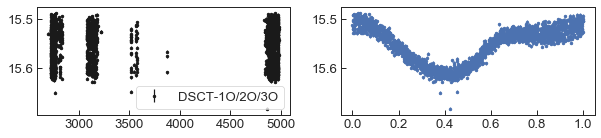

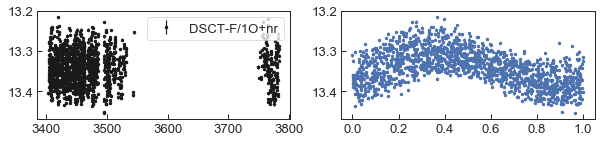

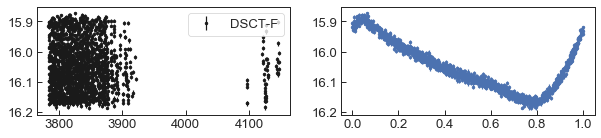

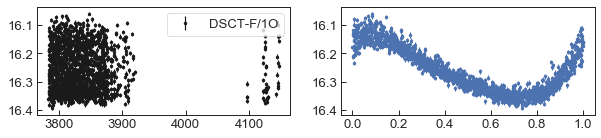

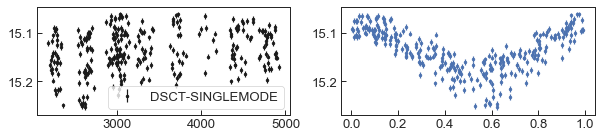

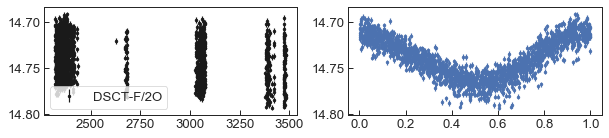

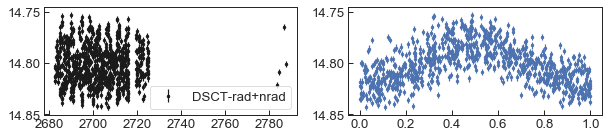

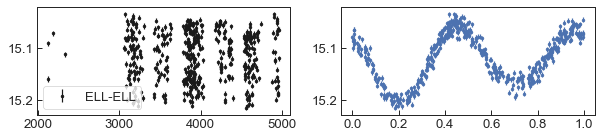

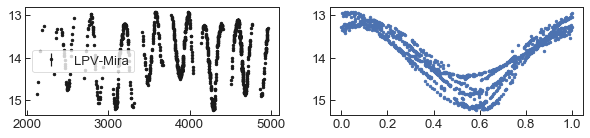

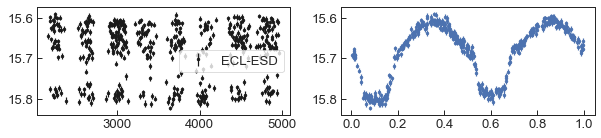

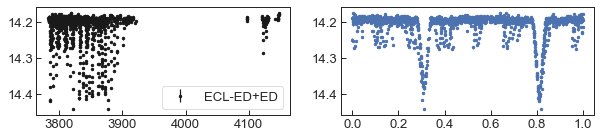

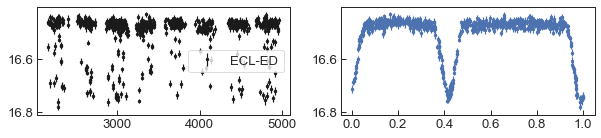

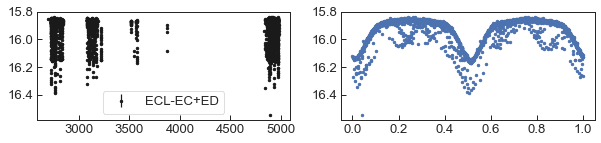

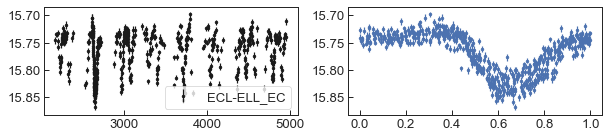

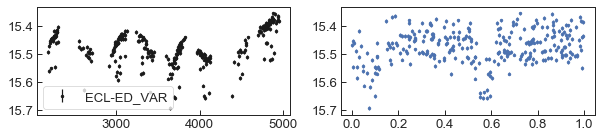

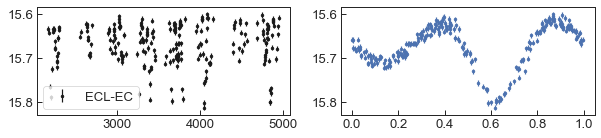

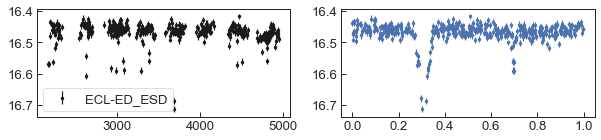

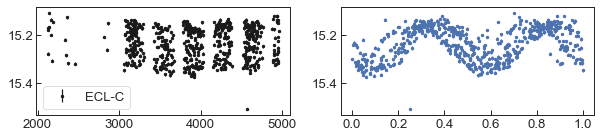

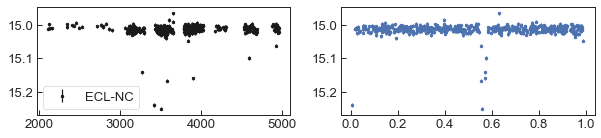

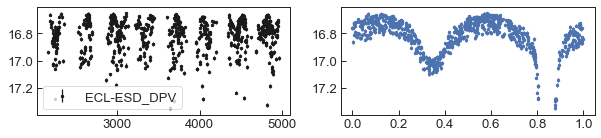

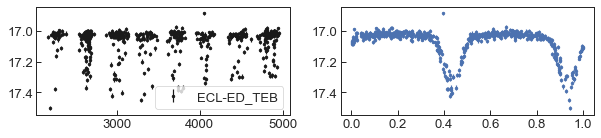

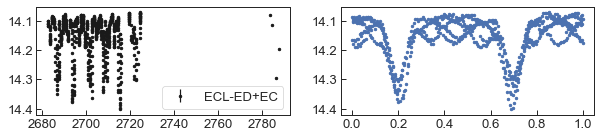

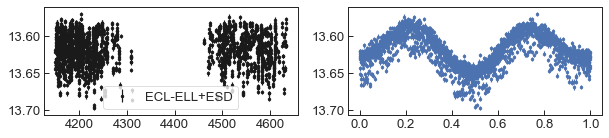

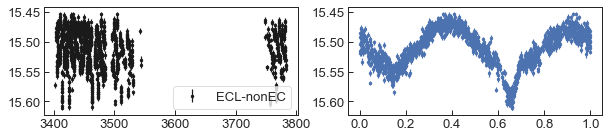

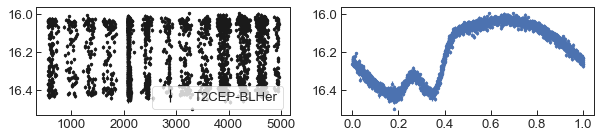

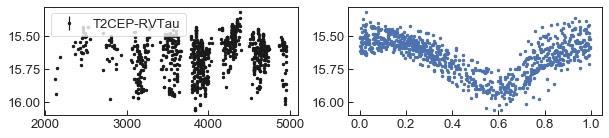

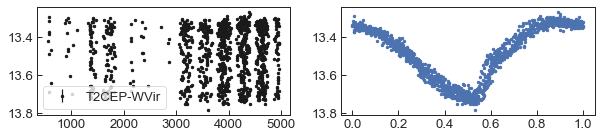

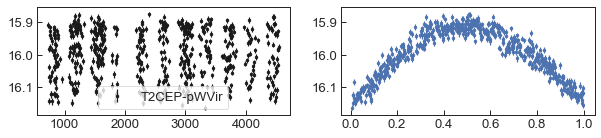

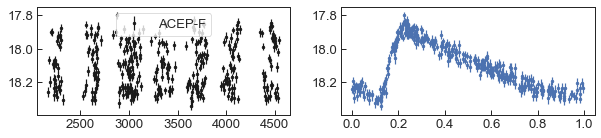

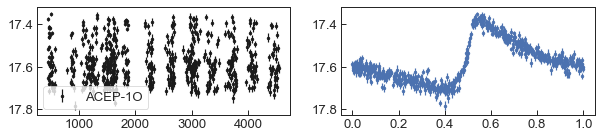

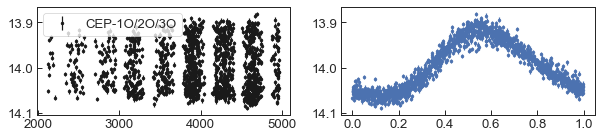

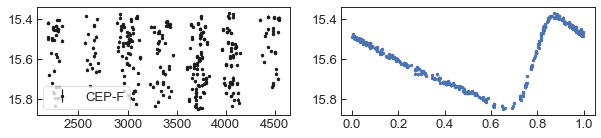

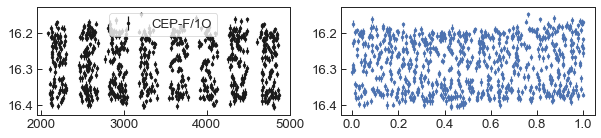

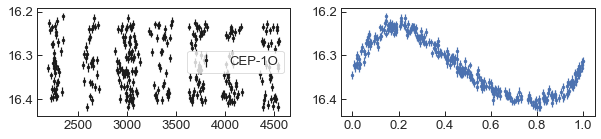

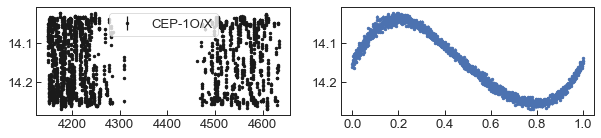

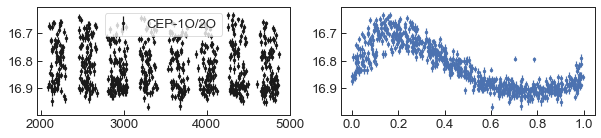

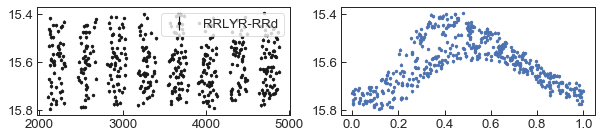

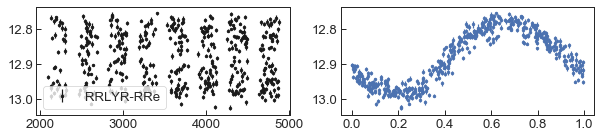

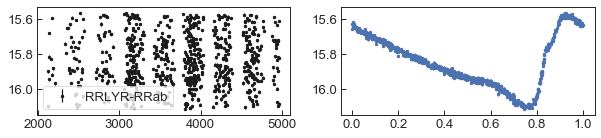

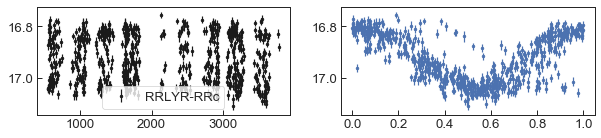

In [15]:
for cl in set(meta.Type):
    for subcl in set(meta.query('Type=="%s"' % cl).subType):
        idx = meta.reset_index().query('Type=="%s" and subType=="%s"' % (cl, subcl)).index.values
        idx = np.random.choice(idx, 1, replace=False)[0]
        P = meta.iloc[idx]['Period']
        lc = lcs[idx]
        fold = fold_lc(lc, P)
        f, ax = plt.subplots(1,2, figsize=(10,2))
        ax[0].errorbar(lc[:,0], lc[:,1], yerr=lc[:,2], fmt='.', c='k',
                         label='%s-%s' % (cl, subcl))
        ax[1].errorbar(fold[:,0], fold[:,1], yerr=fold[:,2], fmt='.', c='b')
        
        ax[0].invert_yaxis()
        ax[1].invert_yaxis()
        ax[0].legend(loc='best')
        plt.show()

### Remove multipel mode variables

In [16]:
mm_subtypes = [['DSCT', '1O/2O+nr'],
               ['DSCT', 'F/1O/2O+nr'],
               ['DSCT', '1O/2O'],
               ['DSCT', 'F/1O/2O'],
               ['DSCT', 'MULTIMODE'],
               ['DSCT', 'F/1O/2O/3O'],
               ['ECL', 'EC+EC'],
               ['CEP', 'F/1O/2O'],
#               ['CEP', 'F/1O'],
               ['LPV', 'osarg'],
               ['LPV', 'O'],
               ['LPV', 'SRV'],
               ['LPV', 'C'],
               ]

idx_to_drop = []
for (cl, sbcl) in mm_subtypes:
    idx = meta.query('Type=="%s" and subType=="%s"' % (cl, sbcl)).index.values
    idx_to_drop.extend(idx)
    
meta_new = meta.drop(idx_to_drop, axis='index').reset_index(drop=True)
lcs_new = np.delete(lcs, idx_to_drop, axis=0)

print(meta_new.shape, lcs_new.shape)
meta_new.Type.value_counts()

(33124, 46) (33124,)


ECL      9508
RRLYR    9324
CEP      7121
LPV      4349
ELL      2269
T2CEP     440
ACEP       71
DSCT       42
Name: Type, dtype: int64

## Data Augmentation

[21501, 6076, 10802, 32738, 33104, 23101, 23136, 14279]


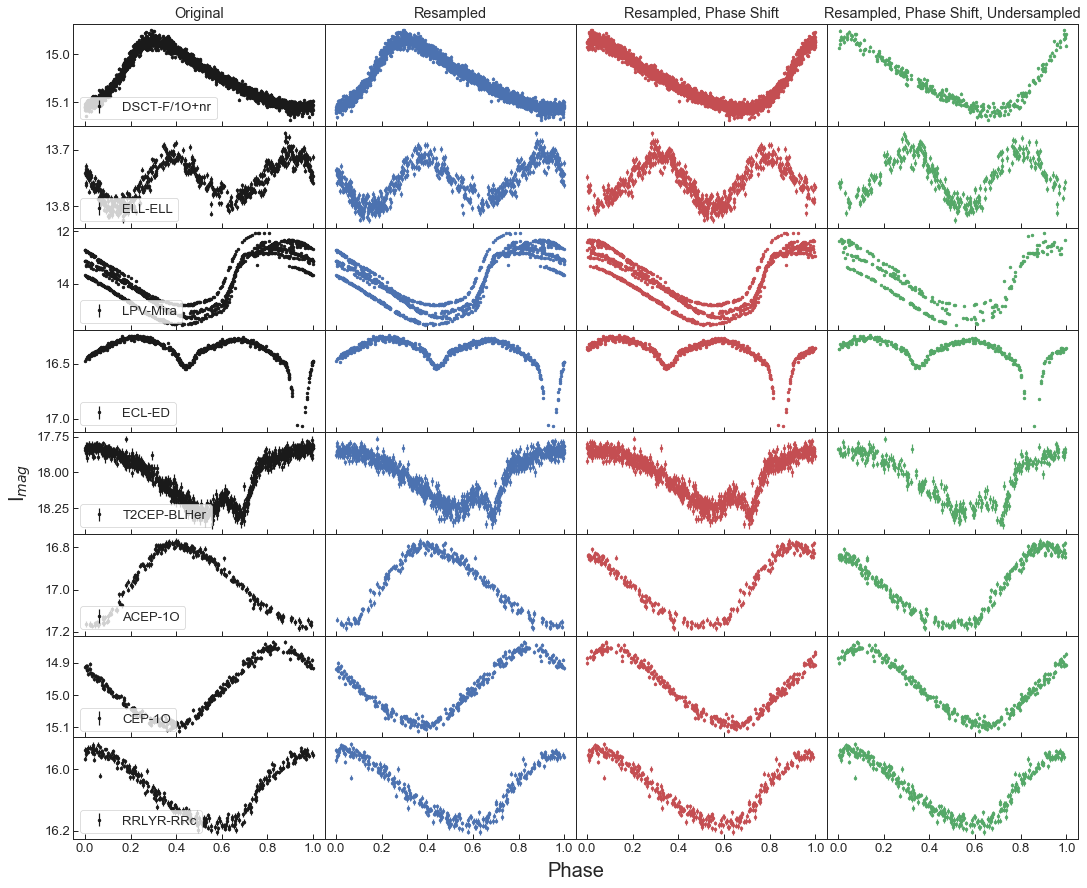

In [17]:
## TEST augmentation techniques:
## resample magnitudes from new_mag_i = N(mag_i, err_i)
## add phase shift to phase-folded light curves
## sample NN random points from phase-folded resampled LCs
NB = 300

eg_idx = []
for cl in set(meta_new.Type):
    eg_idx.extend(np.random.choice(np.where(meta_new.Type == cl)[0], size=1, replace=False))
#eg_idx = [58000, 19912, 7346, 29, 5719, 31847, 47357, 56629] #48467
print(eg_idx)

f, ax = plt.subplots(len(eg_idx),4, figsize=(18,15), sharex=True)
for k, idx in enumerate(eg_idx):
    lc = lcs_new[idx]
    p = meta_new.Period[idx]
    t = meta_new.Type[idx]
    st = meta_new.subType[idx]
    f_org = fold_lc(lc, p)
    new1 = sample_err(f_org)
    new2 = phase_shift(new1)
    new3 = subsample(new2, nb=NB)

    
    ax[k,0].errorbar(f_org[:,0], f_org[:,1], yerr=f_org[:,2], fmt='.', c='k',
                    label='%s-%s' % (t, st))
    ax[k,1].errorbar(new1[:,0], new1[:,1], yerr=new1[:,2], fmt='.', c='b')
    ax[k,2].errorbar(new2[:,0], new2[:,1], yerr=new2[:,2], fmt='.', c='r')
    ax[k,3].errorbar(new3[:,0], new3[:,1], yerr=new3[:,2], fmt='.', c='g')
    
    ax[k,0].invert_yaxis()
    ax[k,0].legend(loc='lower left')
    ax[k,1].invert_yaxis()
    ax[k,1].set_yticks([])
    ax[k,2].invert_yaxis()
    ax[k,2].set_yticks([])
    ax[k,3].invert_yaxis()
    ax[k,3].set_yticks([])
    
ax[4,0].set_ylabel('I$_{mag}$', fontsize=20)
ax[-1,2].set_xlabel('Phase', fontsize=20)
ax[-1,2].xaxis.set_label_coords(.0, -0.220)
plt.subplots_adjust(hspace=0, wspace=0)

ax[0,0].title.set_text('Original')
ax[0,1].title.set_text('Resampled')
ax[0,2].title.set_text('Resampled, Phase Shift')
ax[0,3].title.set_text('Resampled, Phase Shift, Undersampled')

if save_plots:
    plt.savefig('%s/paper_figures/OGLE3_lcs_ex.pdf' % (main_path), 
                format='pdf', bbox_inches='tight')
plt.show()

In [18]:
aug_lcs, aug_meta = [], []
Plot = False

## Augment using sources with physical params first
cnt_dict = dict(ECL  =100,
                ELL  =500,
                RRLYR=200,
                DSCT =100,
                LPV  = 50,
                CEP  = 50,
                T2CEP= 50,
                ACEP =  0)

for k, (vt, nn) in enumerate(meta_new.dropna(
    subset=['lum_val','radius_val']).Type.value_counts().sort_index().items()):
    print(vt, nn, cnt_dict[vt])
    cnt = nn
    _idx = meta_new.query('Type == "%s"' % (vt)).index.values
    while cnt < cnt_dict[vt]:
        rnd_idx = np.random.choice(_idx)
        org_lc = lcs_new[rnd_idx]
        P = meta_new.iloc[rnd_idx].Period
        org_lc_f = fold_lc(org_lc, P)
        new_lc = subsample(phase_shift(sample_err(org_lc_f)), nb=NB)
        aug_lcs.append(new_lc)
        aug_meta.append(meta_new.iloc[rnd_idx])
        cnt += 1
        
    print('final', cnt)
    print('########')
    
print('################')
print('################')
print('AUGMENT ALL')

## Augment using full dataset
counts_dict = dict(ECL  =10000,
                   RRLYR=10000,
                   DSCT = 5000,
                   LPV  =10000,
                   T2CEP= 5000,
                   CEP  =10000,
                   ACEP = 5000,
                   ELL  =10000)

for k, (vt, nn) in enumerate(meta_new.Type.value_counts().sort_index().items()):
    print(vt, nn, counts_dict[vt])
    cnt = nn
    aa = 0
    _idx = meta_new.query('Type == "%s"' % (vt)).index.values
    while cnt < counts_dict[vt]:
        rnd_idx = np.random.choice(_idx)
        org_lc = lcs_new[rnd_idx]
        P = meta_new.iloc[rnd_idx].Period
        org_lc_f = fold_lc(org_lc, P)
        new_lc = subsample(phase_shift(sample_err(org_lc_f)), nb=NB)
        aug_lcs.append(new_lc)
        aug_meta.append(meta_new.iloc[rnd_idx])
        cnt += 1
        
        if np.random.uniform() > .95 and aa < 5 and Plot:
            print(hsnr_meta_new.loc[:,['Type','subType','I','V',
                                       'Period','lum_val',
                                       'radius_val']].iloc[rnd_idx])
            f, ax = plt.subplots(1,2, figsize=(12,2))
            ax[0].errorbar(org_lc_f[:,0], org_lc_f[:,1], yerr=org_lc_f[:,2], 
                           fmt='.', c='k')
            ax[1].errorbar(new_lc[:,0], new_lc[:,1], yerr=new_lc[:,2], 
                           fmt='.', c='b')
            ax[0].invert_yaxis()
            ax[1].invert_yaxis()
            plt.show()
            aa += 1
        
    print('final', cnt)
    print('################')
            
aug_lcs = np.array(aug_lcs)
aug_meta = pd.concat(aug_meta, axis=1).T

CEP 5 50
final 50
########
DSCT 10 100
final 100
########
ECL 1495 100
final 1495
########
ELL 135 500
final 500
########
LPV 6 50
final 50
########
RRLYR 31 200
final 200
########
T2CEP 3 50
final 50
########
################
################
AUGMENT ALL
ACEP 71 5000
final 5000
################
CEP 7121 10000
final 10000
################
DSCT 42 5000
final 5000
################
ECL 9508 10000
final 10000
################
ELL 2269 10000
final 10000
################
LPV 4349 10000
final 10000
################
RRLYR 9324 10000
final 10000
################
T2CEP 440 5000
final 5000
################


In [19]:
aug_meta.Type.value_counts()

ELL      8096
LPV      5695
DSCT     5048
ACEP     4929
T2CEP    4607
CEP      2924
RRLYR     845
ECL       492
Name: Type, dtype: int64

## Fold real LCs & append augmented set

In [20]:
folded_real_sample = []
for lc, p in zip(lcs_new, meta_new.Period.values):
    folded_real_sample.append(subsample(fold_lc(lc, p), nb=NB))
folded_real_sample = np.array(folded_real_sample)
print(folded_real_sample.shape, lcs_new.shape, meta_new.shape)

(33124, 300, 3) (33124,) (33124, 46)


In [21]:
full_ts_lcs = np.vstack([folded_real_sample, aug_lcs])
full_ts_meta = pd.concat([meta_new, aug_meta], 
                         axis=0).reset_index(drop=True)
sort_index = full_ts_meta.sort_values('Type').index.values
full_ts_meta = full_ts_meta.iloc[sort_index].reset_index(drop=True)
full_ts_lcs = full_ts_lcs[sort_index]

full_ts_lcs.shape, full_ts_meta.shape

((65760, 300, 3), (65760, 46))

## Sort LCs by phase value and repeat phase

In [28]:
sorted_lcs = []
with tqdm_notebook(range(len(full_ts_lcs))) as pbar:
    for k, lc in enumerate(full_ts_lcs):
        aux = lc.copy()
        aux[:,0] += 1.
        nlc = np.concatenate([lc, aux])
        idx = np.argsort(nlc[:,0])
        nlc = nlc[idx]
        sorted_lcs.append(nlc)
        pbar.update()
sorted_lcs = np.array(sorted_lcs)

## Cast to float32

In [23]:
for col in meta.columns:
    if col in ['Type', 'OGLE_id','subType','Year','Field']:
        full_ts_meta.loc[:, col] = full_ts_meta.loc[:,col].astype(np.str, error='ignore')
        continue
    if col == 'source_id':
        full_ts_meta.loc[:, col] = full_ts_meta.loc[:,col].astype(np.int64, error='ignore')
    else:
        full_ts_meta.loc[:, col] = full_ts_meta.loc[:,col].astype(np.float32, error='ignore')
full_ts_meta.rename(columns={'source_id':'GAIA_source_id'}, inplace=True)

In [24]:
full_ts_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65760 entries, 0 to 65759
Data columns (total 46 columns):
GAIA_source_id             65760 non-null int64
OGLE_id                    65760 non-null object
Dec                        65760 non-null float32
Period                     65760 non-null float32
RA                         65760 non-null float32
SNR                        65760 non-null float32
Type                       65760 non-null object
subType                    65760 non-null object
V                          62182 non-null float32
V_I                        62182 non-null float32
I                          65760 non-null float32
ra_x                       65760 non-null float32
ra_error                   65760 non-null float32
dec_x                      65760 non-null float32
dec_error                  65760 non-null float32
parallax                   62877 non-null float32
parallax_error             62877 non-null float32
pmdec                      62877 non-null floa

# Save to pkl and Numpy

In [121]:
cols = ['OGLE_id','RA', 'Dec', 'Type', 'subType', 'GAIA_source_id',
        'parallax', 'abs_Gmag',
        'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
        'bp_rp', 'teff_val', 'radius_val', 'lum_val', 
        'SNR', 'I', 'abs_Imag', 'V_I', 'V', 'Period',
        '[Fe/H]_J95', '[Fe/H]_ZW']

In [31]:
## SAVE!
if save_tables:
    to_save = dict(meta=full_ts_meta.loc[:,cols],
                   lcs=sorted_lcs.astype(np.float32))
    np.save('%s/data/OGLE3/OGLE3_lcs_%s_meta_snr5_augmented_folded_trim%i.npy'
            % (main_path, 'I', 600), to_save)

# SUMMARY

In [131]:
set(full_ts_meta.Type)

{'ACEP', 'CEP', 'DSCT', 'ECL', 'ELL', 'LPV', 'RRLYR', 'T2CEP'}

In [132]:
print('Augmented Training set')
print('Total: ', full_ts_meta.shape[0])
print('_____________________')
print(full_ts_meta.Type.value_counts().sort_index())

Augmented Training set
Total:  65760
_____________________
ACEP      5000
CEP      10045
DSCT      5090
ECL      10000
ELL      10365
LPV      10044
RRLYR    10169
T2CEP     5047
Name: Type, dtype: int64


In [88]:
print('Subcalsses per Variability Class')
print('____________________________')
print('____________________________')
for cl in set(full_ts_meta.Type):
    aux = full_ts_meta.query('Type == "%s"' % cl)
    print(cl)
    print(aux.subType.value_counts())
    print('____________________________')

Subcalsses per Variability Class
____________________________
____________________________
DSCT
F             1662
rad+nrad      1056
SINGLEMODE     846
F/1O           819
F/1O+nr        469
F/2O           119
1O/2O/3O       119
Name: subType, dtype: int64
____________________________
T2CEP
BLHer    1826
WVir     1807
RVTau    1132
pWVir     282
Name: subType, dtype: int64
____________________________
ACEP
F     3804
1O    1196
Name: subType, dtype: int64
____________________________
ECL
NC         5020
ED         1317
C          1123
EC          998
nonEC       921
ESD         512
ED_VAR       51
ED_ESD       22
ELL_EC       17
ESD_DPV       7
ED_TEB        7
EC+ED         2
ED+EC         1
ED+ED         1
ELL+ESD       1
Name: subType, dtype: int64
____________________________
LPV
Mira    10044
Name: subType, dtype: int64
____________________________
CEP
F           5995
1O          3454
1O/2O        434
F/1O         155
1O/2O/3O       6
1O/X           1
Name: subType, dtype: int64
_